## Importing libraries

In [1]:
import nltk, warnings, string, re, wordcloud
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Dataset Loading

In [32]:
#The data from the twitter comments:
#There are many stopwords
#The datasource - https://www.kaggle.com/datasets/yasserh/twitter-tweets-sentiment-dataset?select=Tweets.csv
df = pd.read_csv('Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [33]:
#Look at info about dataset - it's ok
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


## Text Preprocessing

In [4]:
#drop data with one letter and the part after apostrophe
def preprocess(text):
    tokens = [word.lower().split("'")[0] for word in re.findall("[a-zA-Z]+'?[a-zA-Z]+", str(text))]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [5]:
#delete stop words
def delete_stop_words(list_of_words):
    return ' '.join([word for word in list_of_words if word not in wordcloud.STOPWORDS])

In [6]:
#lemmatize words
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

In [7]:
#dictionary of stopwords
stop_words = set(stopwords.words('english') + list(string.ascii_lowercase))

In [34]:
#look the data without neutral class for binary classification
df = df[df.sentiment != 'neutral']

In [35]:
#preprocess data
df.text= df.text.apply(preprocess)
df.text = df.text.apply(delete_stop_words)
df.text = df.text.apply(lemmatize_words)

In [36]:
df.sentiment.replace(['positive','negative'],[0,1],inplace=True)

In [37]:
data=df

In [38]:
#the data became better
#In many phrases we see word 'user' but we didn't drop it in stopwords because it gives positive meaning like respect
data

,textID,text,selected_text,sentiment
1,549e992a42,sooo sad miss san diego,Sooo SAD,1
2,088c60f138,bos bullying,bullying me,1
3,9642c003ef,interview leave alone,leave me alone,1
4,358bd9e861,son put release already bought,"Sons of ****,",1
6,6e0c6d75b1,feeding baby fun smile coo,fun,0
...,...,...,...,...
27475,b78ec00df5,enjoy ur night,enjoy,0
27476,4eac33d1c0,wish come see denver husband lost job afford,d lost,1
27477,4f4c4fc327,wondered rake client made clear net force devs...,", don`t force",1
27478,f67aae2310,yay good enjoy break probably need hectic week...,Yay good for both of you.,0


## Data Analysis

In [39]:
#Classes are well balanced
df.sentiment.value_counts()

0    8582
1    7781
Name: sentiment, dtype: int64

In [41]:
#To bulid the WorldCloud mark out tweets to meaning
positive_tweets = ' '.join(list(df[df.sentiment == 0]['text']))
negative_tweets = ' '.join(list(df[df.sentiment == 1]['text']))

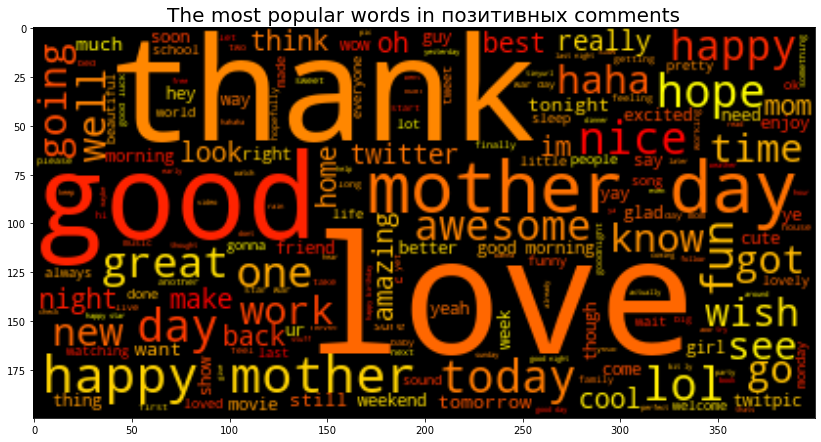

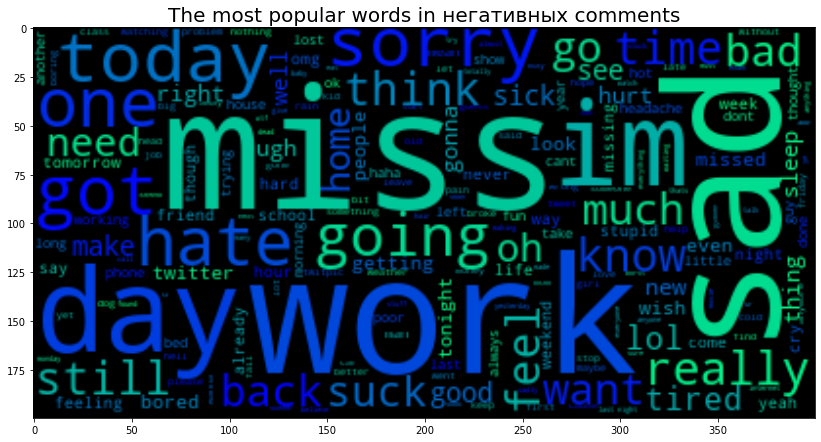

In [49]:
texts = [positive_tweets, negative_tweets]
cmaps = ['autumn', 'winter']
titles = ['позитивных', 'негативных']

for text, cmap, title in zip(texts, cmaps, titles):
    word_cloud = WordCloud(colormap=cmap)
    word_cloud.generate(text)
    plt.figure(figsize=(14, 8))
    plt.title('The most popular words in {} comments'.format(title), fontsize=20)
    plt.imshow(word_cloud, interpolation='bilinear')

## Dividing the dataset into training and test 

In [43]:
X = df.text
y = df.sentiment

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

## Text Vectorization TFIDF

In [45]:
tfidf = TfidfVectorizer()
X_train_vect = tfidf.fit_transform(X_train)
X_test_vect = tfidf.transform(X_test)

## Model Training & Evaluation

In [46]:
#chose methods of machine learning
estimators=[LogisticRegression(), KNeighborsClassifier(), SGDClassifier(), RandomForestClassifier()]

In [47]:
#models training 
#we can use accuracy because the classes are balanced
#we see that accuracy > 0,8 eccept KNN. Recall on the 1 class is too small and precision on 0 class is smaller than
#results of another models
accuracy_list = {}
for model in estimators:
    model.fit(X_train_vect,y_train)
    model_pred = model.predict(X_test_vect)
    print(model)
    print(confusion_matrix(y_test, model_pred))
    print(classification_report(y_test,model_pred))
    accuracy_list[model] = round(accuracy_score(y_test,model_pred),4)

LogisticRegression()
[[2202  332]
 [ 320 2055]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2534
           1       0.86      0.87      0.86      2375

    accuracy                           0.87      4909
   macro avg       0.87      0.87      0.87      4909
weighted avg       0.87      0.87      0.87      4909

KNeighborsClassifier()
[[1534 1000]
 [1040 1335]]
              precision    recall  f1-score   support

           0       0.60      0.61      0.60      2534
           1       0.57      0.56      0.57      2375

    accuracy                           0.58      4909
   macro avg       0.58      0.58      0.58      4909
weighted avg       0.58      0.58      0.58      4909

SGDClassifier()
[[2218  316]
 [ 332 2043]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2534
           1       0.87      0.86      0.86      2375

    accuracy                           0.

## Performance Analysis of all ML Models

In [48]:
#The best accuracy showed SGDClassifier
accuracy_list

{LogisticRegression(): 0.8672,
 KNeighborsClassifier(): 0.5844,
 SGDClassifier(): 0.868,
 RandomForestClassifier(): 0.8576}